<a href="https://colab.research.google.com/github/susanesho/lung-cancer-project/blob/main/Lung_Cancer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS651 Project: Lung Cancer Prediction

Resources:
https://towardsdatascience.com/your-first-apache-spark-ml-model-d2bb82b599dd

https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa 

https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator 

In [ ]:
# Install Pyspark: Python API of Spark
!pip3 install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=ec9b70df0a913562874445b82b7a9acb4c0be3437046f8433875efc9ebe18e5b
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
# Import libraries
from itertools import chain

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import (
    LogisticRegression,
    NaiveBayes,
    DecisionTreeClassifier,
    RandomForestClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Load and Explore Dataset

In [ ]:
# Mount google drive which contains data

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Start spark session to load data

spark = SparkSession \
    .builder \
    .appName('Lung Cancer Project') \
    .getOrCreate()

In [ ]:
spark

In [ ]:
# Load data

file_path = "gdrive/MyDrive/Lungcancer1.csv"
cancer_df = (spark.read
          .format("csv")
          .option("encoding", "UTF-8")
          .option('header', 'true')
          .load(file_path))

#cancer_df = spark.read.csv("gdrive/MyDrive/Lungcancer.csv")

In [ ]:
cancer_df.toPandas()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,P1,33,1,2,4,5,4,3,2,2,...,3,4,2,2,3,1,2,3,4,Low
1,P10,17,1,3,1,5,3,4,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,P100,35,1,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
3,P1000,37,1,7,7,7,7,6,7,7,...,4,2,3,1,4,5,6,7,5,High
4,P101,46,1,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P995,44,1,6,7,7,7,7,6,7,...,5,3,2,7,8,2,4,5,3,High
996,P996,37,2,6,8,7,7,7,6,7,...,9,6,5,7,2,4,3,1,4,High
997,P997,25,2,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
998,P998,18,2,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High


In [ ]:
# Get number of instances
cancer_df.count()

1000

In [ ]:
# Check columns
cancer_df.columns

['Patient Id',
 'Age',
 'Gender',
 'Air Pollution',
 'Alcohol use',
 'Dust Allergy',
 'OccuPational Hazards',
 'Genetic Risk',
 'chronic Lung Disease',
 'Balanced Diet',
 'Obesity',
 'Smoking',
 'Passive Smoker',
 'Chest Pain',
 'Coughing of Blood',
 'Fatigue',
 'Weight Loss',
 'Shortness of Breath',
 'Wheezing',
 'Swallowing Difficulty',
 'Clubbing of Finger Nails',
 'Frequent Cold',
 'Dry Cough',
 'Snoring',
 'Level']

In [ ]:
# Check statistics of features

cancer_df.describe().toPandas()

,summary,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,count,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,mean,None,37.174,1.402,3.84,4.563,5.165,4.84,4.58,4.38,...,3.856,3.855,4.24,3.777,3.746,3.923,3.536,3.853,2.926,None
2,stddev,None,12.00549273690405,0.4905472827736759,2.0303995967598407,2.620476654713393,1.9808328295690911,2.107805219379352,2.126998853813542,1.8485175187206142,...,2.2446162928888995,2.206545681340823,2.2850867864528954,2.0419207723220905,2.270382927754401,2.3880481096020167,1.8325015858279798,2.0390067553955165,1.4746859661292964,None
3,min,P1,14,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,High
4,max,P999,73,2,8,8,8,8,7,7,...,9,8,9,8,8,9,7,7,7,Medium


In [ ]:
# Check datatypes of columns
cancer_df.dtypes

[('Patient Id', 'string'),
 ('Age', 'string'),
 ('Gender', 'string'),
 ('Air Pollution', 'string'),
 ('Alcohol use', 'string'),
 ('Dust Allergy', 'string'),
 ('OccuPational Hazards', 'string'),
 ('Genetic Risk', 'string'),
 ('chronic Lung Disease', 'string'),
 ('Balanced Diet', 'string'),
 ('Obesity', 'string'),
 ('Smoking', 'string'),
 ('Passive Smoker', 'string'),
 ('Chest Pain', 'string'),
 ('Coughing of Blood', 'string'),
 ('Fatigue', 'string'),
 ('Weight Loss', 'string'),
 ('Shortness of Breath', 'string'),
 ('Wheezing', 'string'),
 ('Swallowing Difficulty', 'string'),
 ('Clubbing of Finger Nails', 'string'),
 ('Frequent Cold', 'string'),
 ('Dry Cough', 'string'),
 ('Snoring', 'string'),
 ('Level', 'string')]

### Exploratory Data Visualization (EDA)
Here we visualize:
- General properties of the dataset such as: Cancer Level counts, ...
- Demographic Analysis: Understand Age and Gender properties
- Relationship between health related features
- Correlation between features and target variable (Level)


In [ ]:
# Convert columns with String types to float (except Patient Id and Level)

string_columns = ["Patient Id", "Level"]
cancer_df = cancer_df.select(
    col("Patient Id"),
    *(col(c).cast("float").alias(c) for c in cancer_df.columns if c not in string_columns),
    col("Level"))

#### 1. General Properties 

<Axes: xlabel='Level', ylabel='count'>

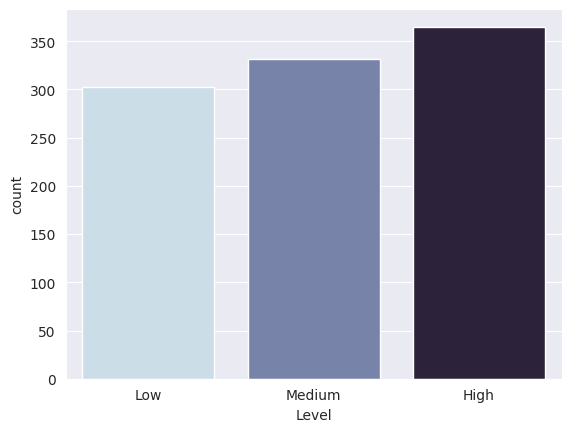

In [ ]:
# Visualize distribution of Lung Cancer level

#cancer_level = cancer_df.groupBy("Level").count().sort("Level", ascending=False)
#cancer_level.toPandas().plot.bar(x='Level',figsize=(6, 4))

sns.countplot(data=cancer_df.toPandas(), x="Level", palette="ch:s=.25,rot=-.25")

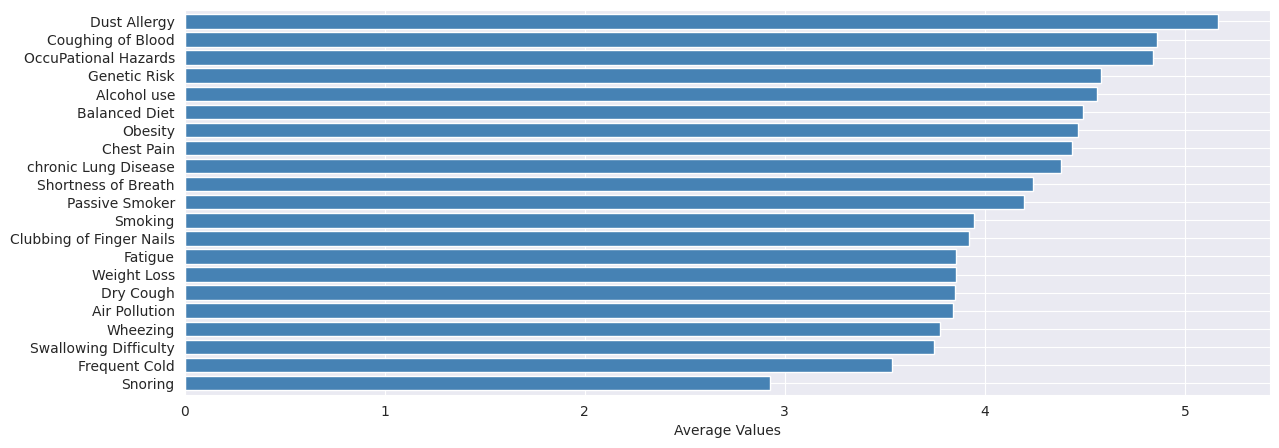

In [ ]:
# Visualize the average values of the different features

except_cols = ['Patient Id', 'Age', 'Gender', 'Level']
select_ft = cancer_df.select([c for c in cancer_df.columns if c not in except_cols])
features_mean = select_ft.toPandas().describe().loc['mean'].sort_values()
features_mean.plot.barh(
    width=0.8, 
    figsize=(14, 5),
    color="steelblue")
plt.xlabel("Average Values")
plt.show()

#### 2. Demographic Analysis

<Axes: xlabel='Level', ylabel='Count'>

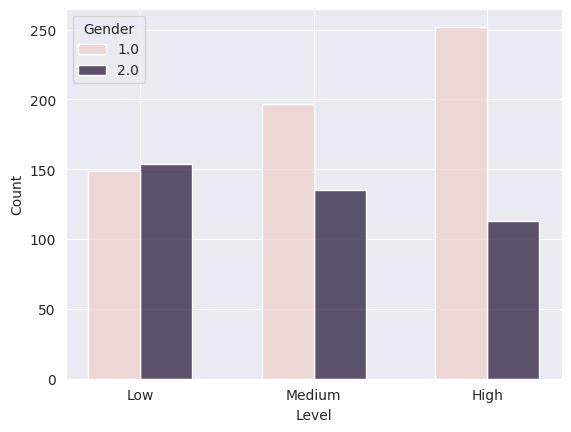

In [ ]:
# Understand gender distribution for each level.

sex_cancer_df = cancer_df.select('Gender', 'Level').toPandas()
sns.histplot(data=sex_cancer_df, x="Level", hue="Gender", multiple="dodge", shrink=.6)

<Axes: xlabel='Age', ylabel='Count'>

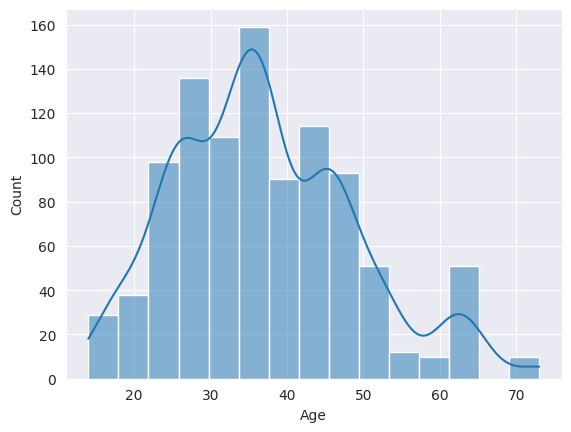

In [ ]:
# Visualize Age distribution
age_df = cancer_df.select(['Age']).toPandas()
sns.histplot(age_df, bins=15, x="Age", kde=True)

<Axes: xlabel='Age', ylabel='Count'>

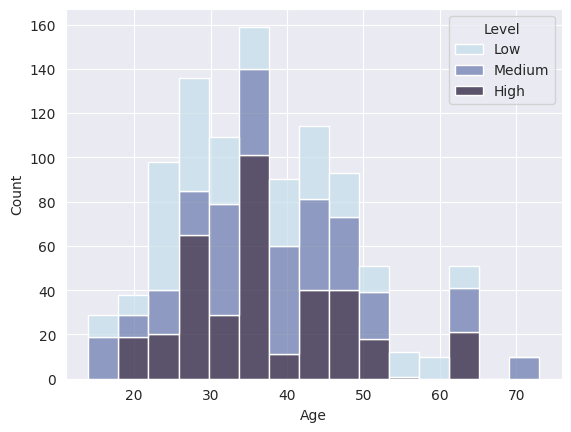

In [ ]:
# Analyse cancer levels at the different ages

age_level_df = cancer_df.select('Age', 'Level').toPandas()
sns.histplot(age_level_df, x="Age", bins=15, hue="Level", multiple="stack", palette="ch:s=.25,rot=-.25")

#### 3. Relationship between health features

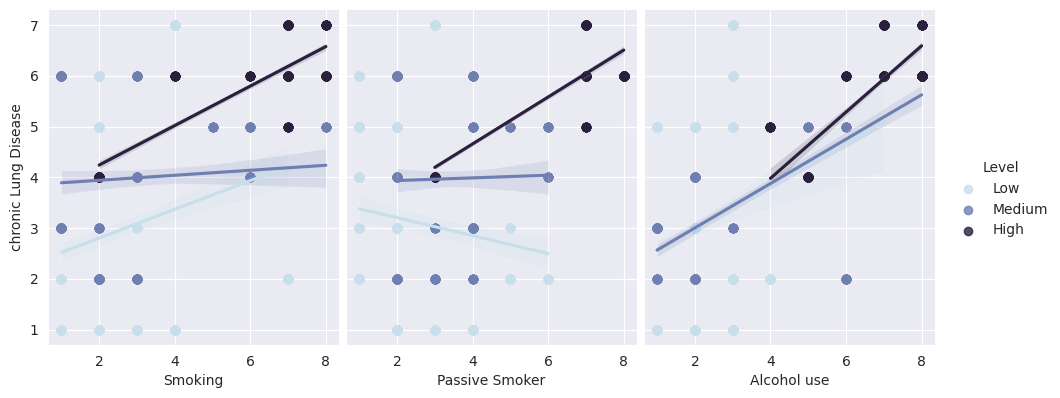

In [ ]:
# Check correlation between Cancer level, Chronic Lung Disease, Smoking and Passive Smoking

smoking_lung_disease = cancer_df.select(
    'chronic Lung Disease', 
    'Smoking', 
    'Passive Smoker',
    'Alcohol use',
    'Level').toPandas()

sns.pairplot(
    smoking_lung_disease,
    x_vars=["Smoking", 'Passive Smoker', 'Alcohol use'],
    y_vars=["chronic Lung Disease"], 
    hue='Level',
    palette="ch:s=.25,rot=-.25",
    kind='reg',
    height=4, aspect=.8,
)

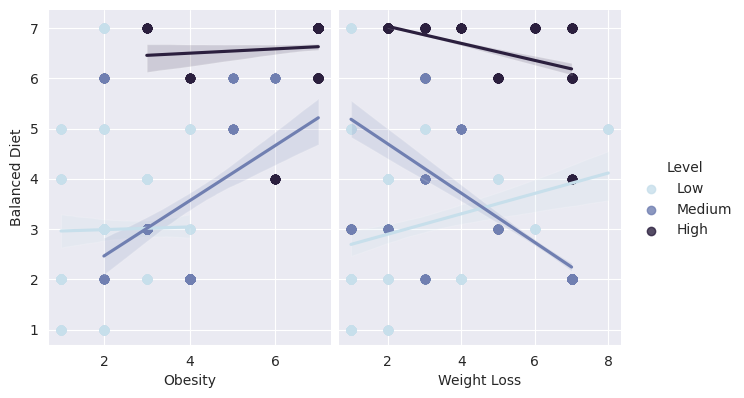

In [ ]:
# Check correlation between Balanced diet, Weight Loss, Obesity

smoking_lung_disease = cancer_df.select(
    'Balanced Diet', 
    'Obesity', 
    'Weight Loss',
    'Level').toPandas()

sns.pairplot(
    smoking_lung_disease,
    x_vars=['Obesity', 'Weight Loss'],
    y_vars=["Balanced Diet"], 
    hue='Level', 
    kind='reg',
    palette="ch:s=.25,rot=-.25",
    height=4, aspect=.8,
)

In [ ]:
# Relationship Genetic Risk and Cancer Level

# cancer_df.dtypes
genetic_risk_level = cancer_df.select('Genetic Risk', 'Level').toPandas()
sns.histplot(
    data=genetic_risk_level, 
    x="Genetic Risk", 
    hue="Level", 
    multiple="dodge", 
    #binwidth=2,
    shrink=.12)

In [ ]:
#sns.lmplot(data=smoking_lung_disease, x='chronic Lung Disease', y='Passive Smoker', hue="Level")

In [ ]:
# Examine Lifestyle factors

plt.figure(figsize=(10,5))
sns.pairplot(cancer_df.select(
    'Smoking',
    'Passive Smoker', 
    'Alcohol use', 
    'Level').toPandas(), kind="reg", hue="Level")
plt.show()

In [ ]:
# Examine Health contributing factors (or Symptoms)

plt.figure(figsize=(8,5))
sns.pairplot(cancer_df.select( 
    'chronic Lung Disease', 
    'Dust Allergy',
    'Genetic Risk',
    'Level').toPandas(), hue="Level")
plt.show()

In [ ]:
# Examine environmental risks 

plt.figure(figsize=(8,5))
sns.pairplot(cancer_df.select(
    'Air Pollution', 
    'OccuPational Hazards', 
    'Level').toPandas(), hue="Level")
plt.show()

In [ ]:
# Examine miscellanous factors

plt.figure(figsize=(15,6))
sns.pairplot(cancer_df.select(
    'Balanced Diet', 
    'Snoring', 
    'Level').toPandas(), hue="Level")
plt.show()

### Data preparation and feature engineering

In [ ]:
# Change Patient ID to just numerical (P23 -> 23)

cancer_df = cancer_df.withColumn("Patient Id", regexp_replace("Patient Id", "P", ""))
cancer_df.toPandas().head()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,1,33.0,1.0,2.0,4.0,5.0,4.0,3.0,2.0,2.0,...,3.0,4.0,2.0,2.0,3.0,1.0,2.0,3.0,4.0,Low
1,10,17.0,1.0,3.0,1.0,5.0,3.0,4.0,2.0,2.0,...,1.0,3.0,7.0,8.0,6.0,2.0,1.0,7.0,2.0,Medium
2,100,35.0,1.0,4.0,5.0,6.0,5.0,5.0,4.0,6.0,...,8.0,7.0,9.0,2.0,1.0,4.0,6.0,7.0,2.0,High
3,1000,37.0,1.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,...,4.0,2.0,3.0,1.0,4.0,5.0,6.0,7.0,5.0,High
4,101,46.0,1.0,6.0,8.0,7.0,7.0,7.0,6.0,7.0,...,3.0,2.0,4.0,1.0,4.0,2.0,4.0,2.0,3.0,High


In [ ]:
# Check for null values 

cancer_df.select([count(when(isnull(c), c)).alias(c) for c in 
                  cancer_df.columns]).show()

# No null values, so we can proceed

+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+-----+
|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|OccuPational Hazards|Genetic Risk|chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring|Level|
+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+-----+
|         0|  0|     0

In [ ]:
# Encode categorical (string type) column ( i.e Level)

# cancer_df = StringIndexer(
#     inputCol='Level', 
#     outputCol='label', 
#     handleInvalid='keep').fit(cancer_df).transform(cancer_df)

# cancer_df.toPandas().head()

mapping = {
    'Low': 1.0,
    'Medium': 2.0,
    'High': 3.0}

mapping_expr = create_map([lit(x) for x in chain(*mapping.items())])
cancer_df = cancer_df.withColumn("label", mapping_expr.getItem(col("Level")))
cancer_df.toPandas().head()

/usr/local/lib/python3.9/dist-packages/pyspark/sql/column.py:419: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level,label
0,1,33.0,1.0,2.0,4.0,5.0,4.0,3.0,2.0,2.0,...,4.0,2.0,2.0,3.0,1.0,2.0,3.0,4.0,Low,1.0
1,10,17.0,1.0,3.0,1.0,5.0,3.0,4.0,2.0,2.0,...,3.0,7.0,8.0,6.0,2.0,1.0,7.0,2.0,Medium,2.0
2,100,35.0,1.0,4.0,5.0,6.0,5.0,5.0,4.0,6.0,...,7.0,9.0,2.0,1.0,4.0,6.0,7.0,2.0,High,3.0
3,1000,37.0,1.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,...,2.0,3.0,1.0,4.0,5.0,6.0,7.0,5.0,High,3.0
4,101,46.0,1.0,6.0,8.0,7.0,7.0,7.0,6.0,7.0,...,2.0,4.0,1.0,4.0,2.0,4.0,2.0,3.0,High,3.0


In [ ]:
# Drop columns we won't need
cancer_df2 = cancer_df.drop('Level')

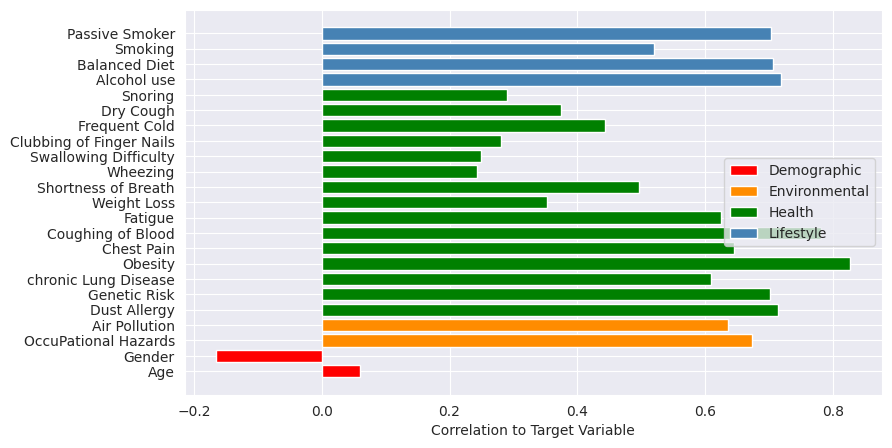

In [ ]:
# Get correlation for the different features by group

demographic_features = ['Age', 'Gender']
environmental_features = ['OccuPational Hazards', 'Air Pollution']
health_features = ['Dust Allergy', 'Genetic Risk',
                   'chronic Lung Disease', 'Obesity',
                   'Chest Pain', 'Coughing of Blood',
                   'Fatigue', 'Weight Loss', 
                   'Shortness of Breath', 'Wheezing',
                   'Swallowing Difficulty', 'Clubbing of Finger Nails',
                   'Frequent Cold', 'Dry Cough', 
                   'Snoring']
lifestyle_features = ['Alcohol use', 'Balanced Diet',
                      'Smoking', 'Passive Smoker']

demograph_corr = [cancer_df.corr(col, 'label') for col in demographic_features]
environ_corr = [cancer_df.corr(col, 'label') for col in environmental_features]
health_corr = [cancer_df.corr(col, 'label') for col in health_features]
lifestyle_corr = [cancer_df.corr(col, 'label') for col in lifestyle_features]

plt.figure(figsize=(9, 5))
dem_plt = plt.barh(demographic_features, demograph_corr, color='red', label='Demographic')
env_plt = plt.barh(environmental_features, environ_corr, color='darkorange', label='Environmental')
health_plt = plt.barh(health_features, health_corr, color='green', label='Health')
life_plt = plt.barh(lifestyle_features, lifestyle_corr, color='steelblue', label='Lifestyle')
plt.xlabel("Correlation to Target Variable")
plt.legend(handles=[dem_plt, env_plt, health_plt, life_plt])
plt.show()

In [ ]:
# Assemble training features with VectorAssembler

input_features = ['Age',
              'Gender',
              'Air Pollution',
              'Alcohol use',
              'Dust Allergy',
              'OccuPational Hazards',
              'Genetic Risk',
              'chronic Lung Disease',
              'Balanced Diet',
              'Obesity',
              'Smoking',
              'Passive Smoker',
              'Chest Pain',
              'Coughing of Blood',
              'Fatigue',
              'Weight Loss',
              'Shortness of Breath',
              'Wheezing',
              'Swallowing Difficulty',
              'Clubbing of Finger Nails',
              'Frequent Cold',
              'Dry Cough',
              'Snoring']

assembler = VectorAssembler(inputCols=input_features, outputCol='features')
transformed_data = assembler.transform(cancer_df2)

In [ ]:
transformed_data.toPandas().head(2)

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,label,features
0,1,33.0,1.0,2.0,4.0,5.0,4.0,3.0,2.0,2.0,...,4.0,2.0,2.0,3.0,1.0,2.0,3.0,4.0,1.0,"[33.0, 1.0, 2.0, 4.0, 5.0, 4.0, 3.0, 2.0, 2.0,..."
1,10,17.0,1.0,3.0,1.0,5.0,3.0,4.0,2.0,2.0,...,3.0,7.0,8.0,6.0,2.0,1.0,7.0,2.0,2.0,"[17.0, 1.0, 3.0, 1.0, 5.0, 3.0, 4.0, 2.0, 2.0,..."


In [ ]:
# Split transformed data into training and test set
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 804
Test Dataset Count: 196


### Model Training

We would implement 4 different models and compare their results:
- Logistic Regression
- Decision Tree classifier
- Random Forest Classifier
- Ensemble of the 3 models above.

Then we examine feature importance for each model.

In [ ]:
# First define a function for Feature Importance

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

1. Logistic Regression model

In [ ]:
# Initialize model
lr_model = LogisticRegression(labelCol='label', 
                            featuresCol='features',
                            maxIter=2)

# Fit the model (train) -> Produces transformer
lr_model = lr_model.fit(training_data)

# Initialize evaluator

def evaluator(model_, model_name):
  predictions = model_.transform(test_data)

  accuracy_evaluator = MulticlassClassificationEvaluator(
      labelCol='label', #Change to cancerlevel
      predictionCol='prediction', 
      metricName='accuracy')
  f1_evaluator = MulticlassClassificationEvaluator(
      labelCol='label', 
      predictionCol='prediction', 
      metricName='f1')
  
  accuracy = accuracy_evaluator.evaluate(predictions)
  f1 = f1_evaluator.evaluate(predictions)

  print(f'Test Accuracy for {model_name} Model = ', accuracy)
  print(f'Test F1 for {model_name} Model = ', f1)
  

evaluator(lr_model, "Logistic regression") 

Test Accuracy for Logistic regression Model =  0.8469387755102041
Test F1 for Logistic regression Model =  0.8379660594593972


2. Decision Tree Classifier

In [ ]:
# Initialize model
dt_model = DecisionTreeClassifier(labelCol='label', 
                            featuresCol='features',
                            maxDepth=3)

# Fit the model (train) -> Produces transformer
dt_model = dt_model.fit(training_data)

# Initialize evaluator
evaluator(dt_model, "Decision trees") 

Test Accuracy for Decision trees Model =  0.9438775510204082
Test F1 for Decision trees Model =  0.9444051901762205


In [ ]:
# Decision Trees feature Importance

varlist = ExtractFeatureImp(dt_model.featureImportances, transformed_data, "features").head(7)
varlist

,idx,name,score
9,9,Obesity,0.445812
17,17,Wheezing,0.287363
14,14,Fatigue,0.138568
2,2,Air Pollution,0.095254
4,4,Dust Allergy,0.033004
0,0,Age,0.000000
13,13,Coughing of Blood,0.000000


<Axes: xlabel='Top Features'>

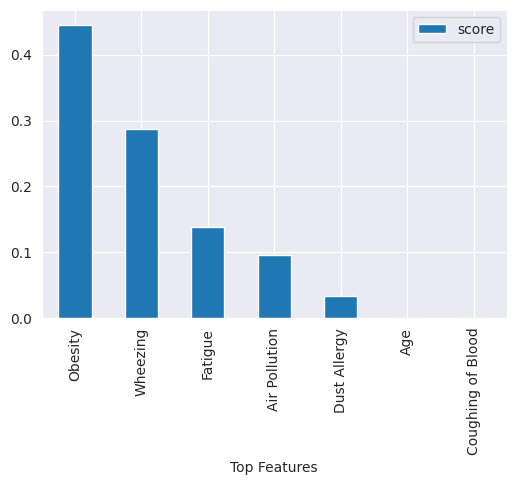

In [ ]:
varlist.plot.bar(x='name',y='score',figsize=(6, 4), xlabel="Top Features")

#### 3. Naive Bayesian

In [ ]:
# Naive Bayes model
nb_model = NaiveBayes(smoothing=10.0)

# Fit the model (train) -> Produces transformer
nb_model = nb_model.fit(training_data)

# Initialize evaluator
evaluator(nb_model, "Naive Bayes") 

Test Accuracy for Naive Bayes Model =  0.1683673469387755
Test F1 for Naive Bayes Model =  0.1679046454479497


3. Random Forest Classifier

In [ ]:
# We would use a Random Forest Classifier as a baseline

# Initialize model
rf_model = RandomForestClassifier(labelCol='label', 
                            featuresCol='features',
                            numTrees=10,
                            maxDepth=3)

# Fit the model (train) -> Produces transformer
rf_model = rf_model.fit(training_data)

In [ ]:
# Evaluate our model
evaluator(rf_model)

Test Accuracy for Logistic Regression Model =  0.9679144385026738
Test F1 for Logistic Regression Model =  0.9677676062720928


In [ ]:
# Random Forest feature Importance

varlist = ExtractFeatureImp(rf_model.featureImportances, transformed_data, "features")
varlist

,idx,name,score
9,9,Obesity,0.181529
13,13,Coughing of Blood,0.166722
6,6,Genetic Risk,0.134710
17,17,Wheezing,0.081668
18,18,Swallowing Difficulty,0.063553
20,20,Frequent Cold,0.057561
16,16,Shortness of Breath,0.044832
15,15,Weight Loss,0.039842
8,8,Balanced Diet,0.036361
14,14,Fatigue,0.036211


<Axes: xlabel='name'>

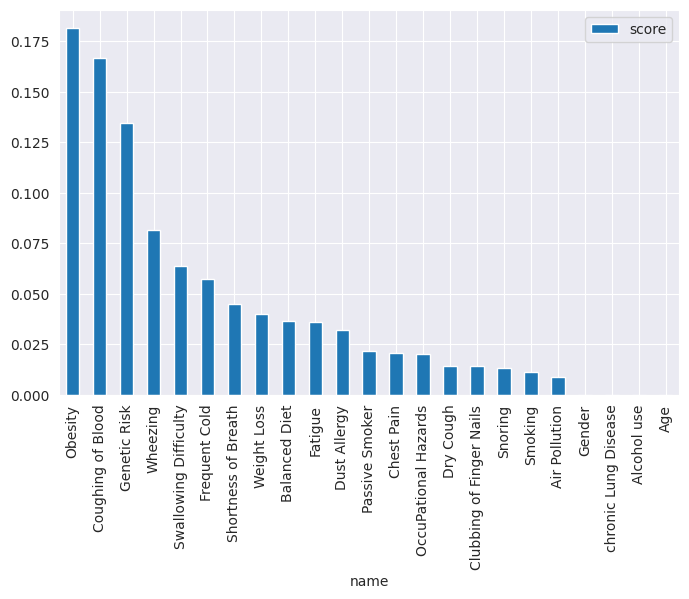

In [ ]:
varlist.plot.bar(x='name',y='score',figsize=(8, 5))

4. Ensemble Model

In [ ]:
dt_predictions.toPandas().tail(3)

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,label,features,rawPrediction,probability,prediction
234,992,26.0,2.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,...,6.0,7.0,2.0,3.0,1.0,0.0,"[26.0, 2.0, 7.0, 7.0, 7.0, 7.0, 7.0, 6.0, 7.0,...","[265.0, 7.0, 17.0, 0.0]","[0.916955017301038, 0.02422145328719723, 0.058...",0.0
235,994,33.0,1.0,6.0,7.0,7.0,7.0,7.0,7.0,6.0,...,7.0,8.0,7.0,6.0,2.0,0.0,"[33.0, 1.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 6.0,...","[265.0, 7.0, 17.0, 0.0]","[0.916955017301038, 0.02422145328719723, 0.058...",0.0
236,996,37.0,2.0,6.0,8.0,7.0,7.0,7.0,6.0,7.0,...,2.0,4.0,3.0,1.0,4.0,0.0,"[37.0, 2.0, 6.0, 8.0, 7.0, 7.0, 7.0, 6.0, 7.0,...","[265.0, 7.0, 17.0, 0.0]","[0.916955017301038, 0.02422145328719723, 0.058...",0.0
